In [2]:
import os
import sys
import numpy as np
from tqdm.auto import tqdm

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model

# Transformers
from transformers import AutoModelForSequenceClassification 

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# 🔹 Image CNN model (from image pipeline)
CNN_MODEL_PATH = "/kaggle/input/fake-news-detectiontrained-image-models/TrainedImageModels/custom_cnn.keras"

# 🔹 Text model (from text pipeline)
TEXT_MODEL_PATH = "/kaggle/input/fake-news-detectiontrained-text-models/checkpoints(large_data)/xlm-roberta-base/checkpoint-995"

# 🔹 Image dataset (same directory used in image pipeline)
IMAGE_DATA_PATH = "/kaggle/input/fake-news-detection-bilingual-multimodel-fusion/news_dataset/for_image"

# 🔹 Text dataset (same CSVs used in text pipeline)
TEXT_DATA_PATH = "/kaggle/input/train-test-val-data-of-different-transformer-model/textdata_large9k"


## Load CNN & Build Feature Extractor

In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D

cnn_model = load_model(CNN_MODEL_PATH)

cnn_input = Input(shape=(256, 256, 3))
x = cnn_input

# 1. Loop through layers but STOP as soon as we hit a Flatten or Dense layer
for layer in cnn_model.layers:
    if "flatten" in layer.name.lower() or "dense" in layer.name.lower():
        break
    x = layer(x)

# 2. Now x is still a 4D spatial tensor. Apply GAP here.
x = GlobalAveragePooling2D()(x) 

cnn_feature_extractor = Model(cnn_input, x)
cnn_feature_extractor.trainable = False

CNN_FEATURE_DIM = x.shape[-1]
print("New CNN feature dimension:", CNN_FEATURE_DIM)

New CNN feature dimension: 128


## Load Text Model(Frozen)

In [6]:
text_model = AutoModelForSequenceClassification.from_pretrained(
    TEXT_MODEL_PATH,
    output_hidden_states=True
)
text_model.eval()

for p in text_model.parameters():
    p.requires_grad = False


## Image Data loader (70 / 15 / 15)

In [7]:
IMG_SIZE = (256, 256)

dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DATA_PATH,
    image_size=IMG_SIZE,
    batch_size=None,
    label_mode="binary",
    shuffle=False  # 🚨 critical
)

def normalize_data(ds):
    return ds.map(lambda x, y: (x / 255.0, y))

def split_data(ds, train_ratio=0.7, val_ratio=0.15):
    total = len(ds)
    train_size = int(total * train_ratio)
    val_size = int(total * val_ratio)

    train = ds.take(train_size)
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size + val_size)

    return train, val, test

dataset = normalize_data(dataset)
train_img, val_img, test_img = split_data(dataset)

print("Train batches:", len(train_img))
print("Validation batches:", len(val_img))
print("Test batches:", len(test_img))


Found 9936 files belonging to 2 classes.
Train batches: 6955
Validation batches: 1490
Test batches: 1491


## Load Text Tensor Data (70 / 15 / 15)

In [8]:
class TextTensorDataset(Dataset):
    def __init__(self, tensor_dict):
        self.input_ids = tensor_dict["input_ids"]
        self.attention_mask = tensor_dict["attention_mask"]
        self.labels = tensor_dict["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

def load_text_data_kaggle(model_name):
    train = torch.load(f"{TEXT_DATA_PATH}/train_tensors_{model_name}.pt")
    val   = torch.load(f"{TEXT_DATA_PATH}/val_tensors_{model_name}.pt")
    test  = torch.load(f"{TEXT_DATA_PATH}/test_tensors_{model_name}.pt")

    return (
        TextTensorDataset(train),
        TextTensorDataset(val),
        TextTensorDataset(test)
    )

train_text_ds, val_text_ds, test_text_ds = load_text_data_kaggle(
    model_name="xlm-roberta-base"
)


## Tensor Data to Image list

In [9]:
def tf_dataset_to_list(ds):
    data = []
    for image, label in ds:
        data.append((image, label))
    return data


train_img_list = tf_dataset_to_list(train_img)
val_img_list   = tf_dataset_to_list(val_img)
test_img_list  = tf_dataset_to_list(test_img)

In [10]:
print("Train images:", len(train_img_list))
print("Validation images:", len(val_img_list))
print("Test images:", len(test_img_list))

print("Train texts:", len(train_text_ds))
print("Validation texts:", len(val_text_ds))
print("Test texts:", len(test_text_ds))

Train images: 6955
Validation images: 1490
Test images: 1491
Train texts: 6340
Validation texts: 1487
Test texts: 1476


## Fusion Dataset

In [11]:
class AlignedFusionDataset(Dataset):
    def __init__(self, img_list, text_ds, length):
        self.img_list = img_list[:length]
        self.text_ds = text_ds
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img, _ = self.img_list[idx]
        text = self.text_ds[idx]

        img = torch.tensor(img.numpy(), dtype=torch.float32).permute(2, 0, 1)

        return {
            "image": img,
            "input_ids": text["input_ids"],
            "attention_mask": text["attention_mask"],
            "label": text["labels"].long()
        }


## Fusion Data loader (70 / 15 / 15)

In [12]:
train_len = min(len(train_img_list), len(train_text_ds))
val_len   = min(len(val_img_list),   len(val_text_ds))
test_len  = min(len(test_img_list),  len(test_text_ds))

print(train_len, val_len, test_len)


6340 1487 1476


In [13]:
train_ds = AlignedFusionDataset(train_img_list, train_text_ds, train_len)
val_ds   = AlignedFusionDataset(val_img_list,   val_text_ds,   val_len)
test_ds  = AlignedFusionDataset(test_img_list,  test_text_ds,  test_len)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


## Late Fusion Model

In [14]:
class LateFusionModel(nn.Module):
    def __init__(self, cnn_tf, bert_pt, num_classes=2):
        super().__init__()
        self.cnn = cnn_tf
        self.bert = bert_pt

        self.classifier = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # ---- CNN (TensorFlow) ----
        imgs = images.permute(0, 2, 3, 1).cpu().numpy()
        cnn_probs = self.cnn.predict(imgs, verbose=0)
        cnn_probs = torch.tensor(
            np.concatenate([1 - cnn_probs, cnn_probs], axis=1),
            device=DEVICE
        )

        # ---- BERT (PyTorch) ----
        with torch.no_grad():
            out = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            bert_probs = torch.softmax(out.logits, dim=1)

        # ---- Fusion ----
        fused = torch.cat([cnn_probs, bert_probs], dim=1)
        return self.classifier(fused)


## Evaluate

In [15]:
def evaluate_model(model, dataloader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:  # <- batch is now a dict
            images = batch["image"].to(device)
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["label"]

            outputs = model(images, ids, mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)

    # Precision / Recall / F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average=None
    )

    macro = precision_recall_fscore_support(
        all_labels, all_preds, average="macro"
    )
    micro = precision_recall_fscore_support(
        all_labels, all_preds, average="micro"
    )
    weighted = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro": macro,
        "micro": micro,
        "weighted": weighted,
        "confusion_matrix": confusion_matrix(all_labels, all_preds),
        "report": classification_report(all_labels, all_preds, digits=4)
    }


## Training loop(xml-RoBERTa)

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

fusion_model = LateFusionModel(cnn_model, text_model).to(DEVICE)
optimizer = optim.Adam(fusion_model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 10

for epoch in range(EPOCHS):
    fusion_model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        optimizer.zero_grad()

        outputs = fusion_model(
            batch["image"].to(DEVICE),
            batch["input_ids"].to(DEVICE),
            batch["attention_mask"].to(DEVICE)
        )

        loss = criterion(outputs, batch["label"].to(DEVICE))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    fusion_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            outputs = fusion_model(
                batch["image"].to(DEVICE),
                batch["input_ids"].to(DEVICE),
                batch["attention_mask"].to(DEVICE)
            )

            loss = criterion(outputs, batch["label"].to(DEVICE))
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch["label"].to(DEVICE)).sum().item()
            total += batch["label"].size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    # Single-line epoch summary
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Using device: cuda


Epoch 1/10:   0%|          | 0/199 [00:00<?, ?it/s]

I0000 00:00:1766095625.806500     128 service.cc:152] XLA service 0x78886800efa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766095625.806548     128 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766095625.806553     128 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766095626.042630     128 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766095629.337759     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/10 | Train Loss: 0.2791 | Val Loss: 0.1563 | Val Acc: 0.9644


Epoch 2/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.0651 | Val Loss: 0.1650 | Val Acc: 0.9650


Epoch 3/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.0598 | Val Loss: 0.1653 | Val Acc: 0.9650


Epoch 4/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.0656 | Val Loss: 0.1721 | Val Acc: 0.9637


Epoch 5/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.0661 | Val Loss: 0.1634 | Val Acc: 0.9637


Epoch 6/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.0496 | Val Loss: 0.1802 | Val Acc: 0.9650


Epoch 7/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0564 | Val Loss: 0.1746 | Val Acc: 0.9650


Epoch 8/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0568 | Val Loss: 0.1701 | Val Acc: 0.9637


Epoch 9/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0569 | Val Loss: 0.1628 | Val Acc: 0.9637


Epoch 10/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.0537 | Val Loss: 0.1720 | Val Acc: 0.9637



=== VALIDATION RESULTS ===
Accuracy: 0.9636852723604573

Classification Report:
              precision    recall  f1-score   support

           0     0.9775    0.9560    0.9667       819
           1     0.9475    0.9731    0.9601       668

    accuracy                         0.9637      1487
   macro avg     0.9625    0.9645    0.9634      1487
weighted avg     0.9640    0.9637    0.9637      1487



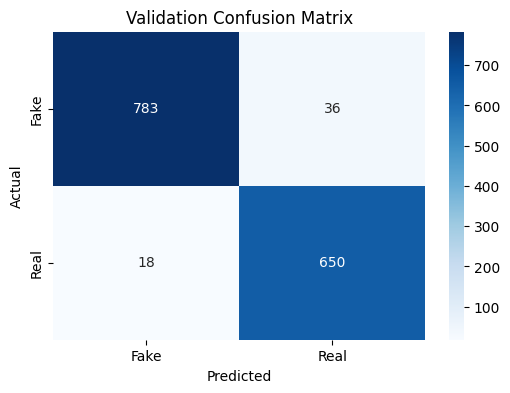


=== TEST RESULTS ===
Accuracy: 0.9715447154471545

Classification Report:
              precision    recall  f1-score   support

           0     0.9860    0.9616    0.9737       807
           1     0.9550    0.9836    0.9691       669

    accuracy                         0.9715      1476
   macro avg     0.9705    0.9726    0.9714      1476
weighted avg     0.9720    0.9715    0.9716      1476



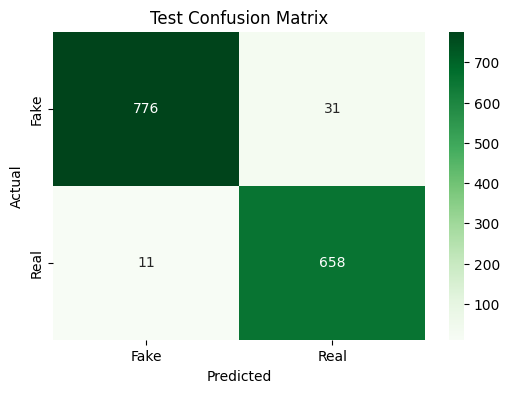

In [17]:
# Evaluation: Validation Set
val_metrics = evaluate_model(fusion_model, val_loader, DEVICE)

print("\n=== VALIDATION RESULTS ===")
print("Accuracy:", val_metrics["accuracy"])
print("\nClassification Report:")
print(val_metrics["report"])

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    val_metrics["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()


# ===============================
# Evaluation: Test Set
# ===============================
test_metrics = evaluate_model(fusion_model, test_loader, DEVICE)

print("\n=== TEST RESULTS ===")
print("Accuracy:", test_metrics["accuracy"])
print("\nClassification Report:")
print(test_metrics["report"])

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    test_metrics["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()


## Training loop(mBERT)

In [50]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

fusion_model = LateFusionModel(cnn_model, text_model).to(DEVICE)
optimizer = optim.Adam(fusion_model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 10

for epoch in range(EPOCHS):
    fusion_model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        optimizer.zero_grad()

        outputs = fusion_model(
            batch["image"].to(DEVICE),
            batch["input_ids"].to(DEVICE),
            batch["attention_mask"].to(DEVICE)
        )

        loss = criterion(outputs, batch["label"].to(DEVICE))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    fusion_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            outputs = fusion_model(
                batch["image"].to(DEVICE),
                batch["input_ids"].to(DEVICE),
                batch["attention_mask"].to(DEVICE)
            )

            loss = criterion(outputs, batch["label"].to(DEVICE))
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch["label"].to(DEVICE)).sum().item()
            total += batch["label"].size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    # Single-line epoch summary
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Using device: cuda


Epoch 1/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.2850 | Val Loss: 0.1824 | Val Acc: 0.9590


Epoch 2/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.0233 | Val Loss: 0.2433 | Val Acc: 0.9583


Epoch 3/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.0189 | Val Loss: 0.2664 | Val Acc: 0.9583


Epoch 4/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.0213 | Val Loss: 0.2729 | Val Acc: 0.9590


Epoch 5/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.0165 | Val Loss: 0.2882 | Val Acc: 0.9583


Epoch 6/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.0154 | Val Loss: 0.2960 | Val Acc: 0.9590


Epoch 7/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0180 | Val Loss: 0.2954 | Val Acc: 0.9590


Epoch 8/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0185 | Val Loss: 0.2841 | Val Acc: 0.9590


Epoch 9/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0184 | Val Loss: 0.2931 | Val Acc: 0.9590


Epoch 10/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.0174 | Val Loss: 0.2965 | Val Acc: 0.9583



=== VALIDATION RESULTS ===
Accuracy: 0.9583053127101546

Classification Report:
              precision    recall  f1-score   support

           0     0.9702    0.9536    0.9618       819
           1     0.9443    0.9641    0.9541       668

    accuracy                         0.9583      1487
   macro avg     0.9572    0.9588    0.9579      1487
weighted avg     0.9585    0.9583    0.9583      1487



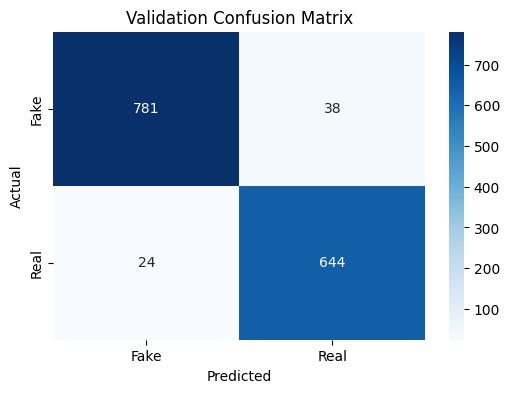


=== TEST RESULTS ===
Accuracy: 0.9715447154471545

Classification Report:
              precision    recall  f1-score   support

           0     0.9823    0.9653    0.9738       807
           1     0.9590    0.9791    0.9689       669

    accuracy                         0.9715      1476
   macro avg     0.9707    0.9722    0.9713      1476
weighted avg     0.9718    0.9715    0.9716      1476



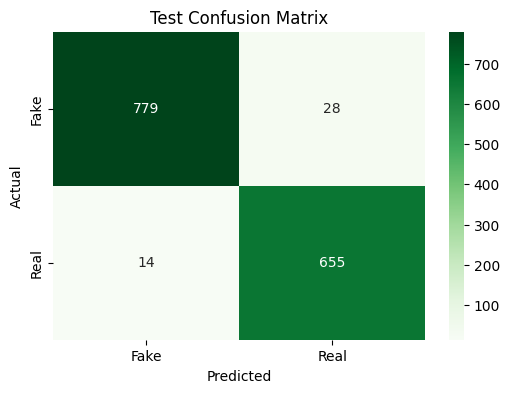

In [54]:
# Evaluation: Validation Set
val_metrics = evaluate_model(fusion_model, val_loader, DEVICE)

print("\n=== VALIDATION RESULTS ===")
print("Accuracy:", val_metrics["accuracy"])
print("\nClassification Report:")
print(val_metrics["report"])

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    val_metrics["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()


# ===============================
# Evaluation: Test Set
# ===============================
test_metrics = evaluate_model(fusion_model, test_loader, DEVICE)

print("\n=== TEST RESULTS ===")
print("Accuracy:", test_metrics["accuracy"])
print("\nClassification Report:")
print(test_metrics["report"])

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    test_metrics["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()
